# Feature Engineering

In this notebook, we generate new features to be used in the dataset for our models. We will include a feature name, description of the feature, justification for adding the feature, and a function to implement the feature for the data

## Features From Data

The following features are variables from the data given to us from the kaggle competition that we believe to be valuable for our models: 
- From players.csv file:
    - position: position of the player (character)
    - weight: weight in lbs for defender (numeric)
    - ballCarrier_position: position of ball carrier (character)
    - weight_ballCarrier: weight in lbs for ball carrier (numeric)
- From plays.csv file:
    - passProbability: NGS probability of nex play being pass based on model, not the actually probability of pass being caught (numeric)
    - preSnapWinProbabilityDefense: Win probability for visitor team (numeric)
    - defendersInTheBox: Number of defenders in close proiximity to line-of-scrimmage (numeric)
    - offenseFormation: Formation used by possession team (more on varibale down below) (character)
    - absoluteYardlineNumber: Distnace from enzone for possession team (numeric)
    - down: down of the play (numeric)
    - yardsToGo: distance to get first down (numeric)
- From tracking_week_#.csv files: 
    - x: player position along the long axis of the field (0-120 yards) (numeric)
    - y: player position along the wide axis of the field (0 - 53.3 yards) (numeric)
    - s: speed in yards/sec (numeric)
    - a: speed in yards/sec^2 (numeric)
    - o: player orientation (deg), 0-360 (numeric)
    - dir: angle of player motion (deg), 0 - 360 degrees (numeric)
    - football_x: football position along the long axis of the field (0-120 yards) (numeric) (not directly in data)
    - football_y: football position along the wide axis of the field (0 - 53.3 yards) (numeric) (not directly in data)
- From tackles.csv file: 
    - tackle: 0 or 1 indicating if the tackle was awarded (not direclty in data) (Dependent Variable)


## Orient Angle

As the data was given to us from the competition, the the degrees of the angle is oriented differently to calculate unit vectors and direction angles in Math. The players orientation starts at 0&deg; facing vertically up the sideline going in the clockwise direction. Thus, we must change the orientation such that the players orientation starts a 0&deg; facing horizontally across the endzone in the right direction, going in the counter clockwise direction. This function performs that task.

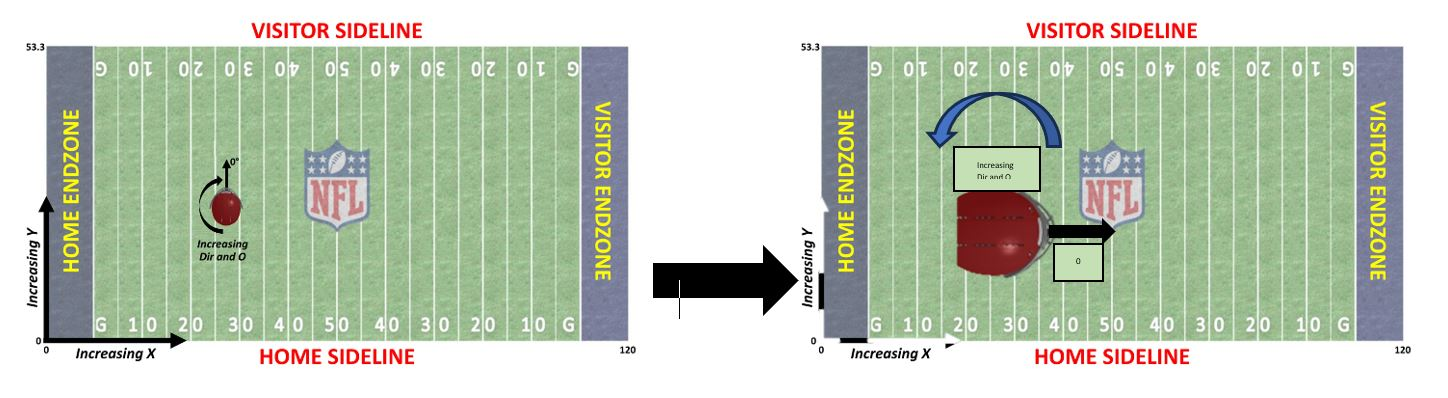

In [7]:
from IPython.display import Image
Image(filename = '../Images/field_orientation.png')

In [1]:
# orient_angle: function to obtain correct unit circle orientation of the angles on the field for further calculations
# input: angle
# output: oriented angle in terms of the unit circle
# Example Usage: tracking["unitO"] = tracking["o"].apply(orient_angle)
def orient_angle(angle):
    if angle >=0 and angle < 90:
        return (90-angle)
    if angle >=90 and angle <180:
        return ((180-angle)+270)
    if angle >=180 and angle < 270:
        return ((270 -angle)+180)
    else:
        return(180-(angle - 270))

## Distance and Angle Difference Between Defender and Offensive Players

The next set of functions include the proper programming to obtain the the distance between a given defender and all offensive players, including ball carrier. We are treating our units of data as a defender for each frame in a play and need to incorporate the position of offensive players to encapsulate blocking. We also need to calculate the angle diference between a defender and an offensive player (a value between 0 and 180 assuming that the player will turn to the quick direction of the each player/ball carrier. 

In the image below, we identify exactly what these functions are calculating. At the center of the cluster is the point which represents the x, y coordinates of a defender on a given fram of a play. Each white circle is a offensive player on the field. The black dot in the middle of one of the white circles represent the ball carrier. Each white line represents the distances from the defensive player to the offensive players. The number in black text represent the distances in yards. The blue arrow represents the unit vector of the direction angle of the defender is heading towards. The red circular line with the stick out lines represent all the angles from the defensive player to all the offensive playerrs and the numbers in red text represent the angle difference between the defensive player and all offensive players in terms of 0 to 180.

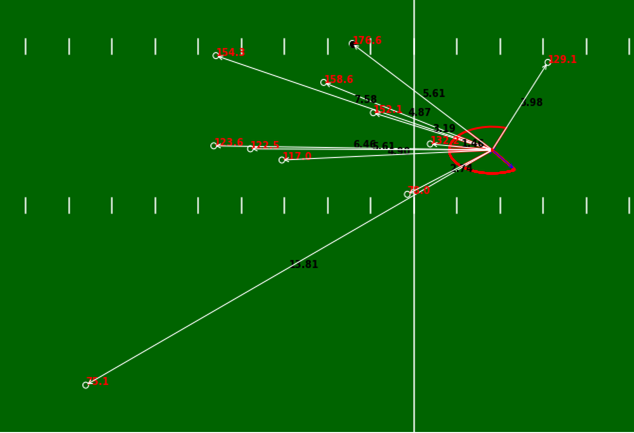

In [8]:
Image(filename = '../Images/distances and angles.png')

In [2]:
# calculate_angle: function to obtain angle between defender and one offensive player to determine the angle direction away
#                  from the given player
# input: x_defender: x_position on the field for defender,
#        y_defender: y_position on the field for defender,
#        x_offense: x_position on the field for one offensive player
#        y_offense: y_position on the field for one offensive player
#        defender_dir_angle: direction angle on the field based on the defensive player
# output: angle difference between offensive player and defender with a value between 0 and 180
# Example Usage: calculate_angle(def_player['x'], def_player['y'], off_player['x'], off_player['y'], def_player["unitDir"])
def calculate_angle(x_defender, y_defender, x_offense, y_offense, defender_dir_angle):
    import math
    import numpy as np
    
    #Determine the difference in x and y components
    delta_x = x_offense - x_defender
    delta_y = y_offense - y_defender
    
    # Calculate the angle in radians to determined direction
    angle_radians = np.arctan2(delta_y, delta_x)
    
    # Convert the angle to degrees and ensure it's within the [0, 360) range
    angle_degrees = (np.degrees(angle_radians))
    
    if (angle_degrees < 0).all():
        angle_degrees = 360 - abs(angle_degrees)
    
    #How far away is the angle of the player from the trajectory
    angle_degrees = abs(defender_dir_angle - angle_degrees)
    
    
    #Orient angle correctly for player to get value between 180 and 360
    if (angle_degrees > 180).all():
        angle_degrees = 360 - angle_degrees
    
    return angle_degrees

In [ ]:
# calculate_distance: function to obtain distance between offensive player and defensive player
# input: x_defender: x_position on the field for defender,
#        y_defender: y_position on the field for defender,
#        x_offense: x_position on the field for one offensive player
#        y_offense: y_position on the field for one offensive player
# output: distance between offensive player and defender
# Example Usage: calculate_distance(def_player['x'], def_player['y'], off_player['x'], off_player['y'])
def calculate_distance(x_defender, y_defender, x_offense, y_offense):
    from math import sqrt
    return sqrt((x_offense - x_defender) ** 2 + (y_offense - y_defender) ** 2)

In [3]:
# calculate_distance_angles: function to obtain distance between offensive player and defensive player
# input: tracking: tracking data
#        plays: play data
#        NOTE: data must have UnitDir variable to compute angles properly
# output: a data frame that includes gameId, playId, nflId, frameId, 
#         c#Dist: the # closest offensive player to the defender
#         c#Ang: the # closes offensive players' respective angle away from defender
#         bcDist: ball carrier distance from defender
#         bcAng: ball carrier angle from defender
# Example Usage: tracking = tracking.merge(calculate_distance_angles(tracking, plays), on = ["gameId", "playId", "nflId", "frameId"])
def calculate_distance_angles(tracking, plays):
    import math
    # Merge tracking data with plays data and the columns needed to identify defensive team and ballcarrier
    data = tracking.merge(plays[["gameId","playId","defensiveTeam","ballCarrierId"]], how="inner", on=["gameId","playId"])

    # Prepare columns for distances (c1Dist, c2Dist, ..., c10Dist)
    for i in range(1, 11):
        data[f'c{i}Dist'] = None

    # Prepare columns for angles (c1Ang, c2Ang, ..., c10Ang)
    for i in range(1, 11):
        data[f'c{i}Ang'] = None

    # Prepare columns for ball carrier distance and angle
    data["bcDist"] = None
    data["bcAng"] = None

    # Process each game, play, and frame
    for (game_id, play_id), play_data in data.groupby(['gameId', 'playId']):
        # Determine the defensive team for this play
        defensive_team = play_data.iloc[0]['defensiveTeam']
        ballCarrierId = play_data.iloc[0]['ballCarrierId']

        #Iterate through each frame 
        for frame_id, frame_data in play_data.groupby('frameId'):
            # Separate defensive and offensive players disregarding the football
            defensive_players = frame_data[frame_data['club'] == defensive_team]
            offensive_players = frame_data[(frame_data['club'] != defensive_team) & (frame_data['displayName'] != "football")]

            #Iterate through each defender on the play to caclulate distances and angles from each offensive player
            for index, def_player in defensive_players.iterrows():
                # Calculate distances to all offensive players except the ball carrier
                distances_angles = [
                    (calculate_distance(def_player['x'], def_player['y'], off_player['x'], off_player['y']),
                     calculate_angle(def_player['x'], def_player['y'], off_player['x'], off_player['y'], def_player["unitDir"]))
                    for _, off_player in offensive_players.iterrows()
                    if off_player['nflId'] != ballCarrierId
                ]

                # Sort distances_projections by distances in ascending order
                distances_angles.sort(key=lambda x: x[0])

                # Update the DataFrame with sorted distances and projections
                for i, (dist, angle) in enumerate(distances_angles[:10], start=1):
                    data.loc[index, f'c{i}Dist'] = dist
                    data.loc[index, f'c{i}Ang'] = angle

                # Update the DataFrame with ball carrier distance and Projection
                bc_dist = calculate_distance(def_player['x'], def_player['y'],
                                   offensive_players[offensive_players["nflId"] == ballCarrierId]['x'],
                                   offensive_players[offensive_players["nflId"] == ballCarrierId]['y'])
                bc_angle = calculate_angle(def_player['x'], def_player['y'],
                             offensive_players[offensive_players["nflId"] == ballCarrierId]['x'],
                             offensive_players[offensive_players["nflId"] == ballCarrierId]['y'],
                             def_player["unitDir"])
                data.loc[index, 'bcDist'] = bc_dist
                data.loc[index, 'bcAng'] = float(bc_angle.iloc[0])

    return data[["gameId", "playId", "nflId", "frameId",
                 "c1Dist", "c2Dist", "c3Dist", "c4Dist", "c5Dist", "c6Dist", "c7Dist", "c8Dist", "c9Dist", "c10Dist", "bcDist",
                 "c1Ang", "c2Ang", "c3Ang", "c4Ang", "c5Ang", "c6Ang", "c7Ang", "c8Ang", "c9Ang", "c10Ang", "bcAng"]]

# Dependent variable: Tackle

For the dependent variable, we are going to create two variables to choose from as our label. In the tracking, there is a frame level description of a major event occuring on the play, this includes descriptions such as "tackle", "pass thown", "handoff", "run", etc. There are certain descriptions that lead us to believe that we have a tackle or not. Event descriptions including the following: "tackle", "out_of_bounds", "fumble", "qb_slide", "saftey". These events allow us to match the player with the corresponding tackle/assist. In the tackles data frame, we can identify which player/players had the tackle with a binary value of 1 for the column of "tackle" or "assist". We will create a dependent variable called **tackle_single** which identifies that we are labeling a 1 or 0 binary value to a player on a frame of a play for a single frame.

Now, this creates some descrepencies because a tackle does not occur for .1 of a second. It may be difficult for our model to tell the difference between a tackle and nontackle becuase the data could look the exact same, but however recorded the tackle at the exact second may not be exactly accurate. A tackle can occur over multiple tenthes of a seconds. Thus, we are going to create a second dependent variable to play around with called **tackle_multiple** which will assign binary values to the tackles on a frame of a given play given the recorded event on that frame, but also to the 0.2 seconds (2 frames) before the tackle, and 0.2 seconds (2 frames) after the tackle, which would allow for a half a second (5 frames) buffer for the model to determine the difference between a tackler and nontackler. NOTE: This variable must be run before removing frames from the play (see more information on filter_frames_by_events). NOTE: we have identified that most of our frames have at least 4 frames after the tackle being recorded, which means that our analysis with the dependent variable should be accurate with having half a second of dependent vairable for each tackle on a play.

In [9]:
#tackle_dependent_variable: function to obtain appropriate dependent variables: tackle_single and tackle_multipl
#Input: tackles: tackling data
#       tracking: tracking data
#Output: data frame with gameId, playId, frameId, nflId, tackle_single, tackle_multiple
#Example Usage: tracking = tracking.merge(tackle_dependent_variable(tackles,tracking), on = ["gameId", "playId", "nflId", "frameId"])
def tackle_dependent_variable(tackles,tracking):
    
    #merge tracking and tackles
    merged = pd.merge(tracking, tackles, on = ['gameId','playId', 'nflId'], how = 'left')   

    #create a new variable called tackle_single for the player who made the tackle on at the instance they made the tackle have a value of 1 and 0 otherwise
    merged["tackle_single"] = merged.apply(
        lambda row: 1 if ((row['tackle'] == 1 or row['assist'] == 1) and 
                          (row["event"] == "tackle" or row["event"] == "out_of_bounds" or row["event"]=="fumble" or row["event"]=="qb_slide" or row["event"]=="safety")) else 0,
        axis=1)    
    print("tackle_single variable done")
    
    
    
    ####Create new variable for tackle_multiple for player who made tackle 2 frames before and 2 frames after
    
    
    # Subset the DataFrame where tackle_single equals 1
    subset_tracking = merged[merged['tackle_single'] == 1][["gameId", "playId", "frameId", "nflId"]]
    
    # Create an empty list to store the new rows
    new_rows = []
    
    # Iterate through the rows of the subset DataFrame
    for index, row in subset_tracking.iterrows():
        # Get the gameId, playId, and tackle_single values
        gameId = row['gameId']
        playId = row['playId']
        nflId = row['nflId']

        # Generate new rows with frame values incremented and decremented by 1 and 2
        for frame_offset in range(-2, 3):
            new_frame = row['frameId'] + frame_offset
            # Ensure the frame value is valid (greater than 0)
            if new_frame > 0:
                # Append a new row with updated frame value
                new_rows.append({'gameId': gameId, 
                                 'playId': playId, 
                                 'frameId': new_frame,
                                 'nflId': nflId,
                                'tackle_multiple': 1})
                
    print("tackle_multiple done")

    # Convert the list of new rows to a DataFrame
    new_df = pd.DataFrame(new_rows)
    
    # Merge tackle single variable dataframe with new data (left join to keep possible frames that might be missing in tackle_multiple df)
    merged = pd.merge(merged,new_df,on=['gameId', 'playId', 'frameId','nflId'], how = 'left')
    
    #fille na values with 0
    merged.fillna(0,inplace = True)

    #return gameId, playId, frameId, nflId, tackle
    return merged[["gameId","playId","frameId","nflId", "tackle_single", "tackle_multiple"]]

# Ball Carrier Data

The following function will assign vital data about the ball carrier to the tracking of each play for the defender. This includes x and y coordinates on the field, speed, acceleration, orientation, direction, force, of the ball Carrier.

In [15]:
# ballCarrierData: takes plays, tracking, and players data to compute important data to include ball carrier data
#                  for each tracking aspect in our data
# input: plays: plays data
#        tracking: tracking data
#        players: players data
#        NOTE: the orient angles must be compute beforehand to return current direction and orientation of ball carrier
# output: a dataframe of all ball carrier information on a given play and frame
# usage: tracking.merge(ballCarrierData(plays,tracking,players), on = ["gameId", "playId", "frameId"])
def ballCarrierData(plays,tracking,players):
    plays_tracking = tracking.merge(plays, on = ['gameId','playId'], how = 'inner') #merge plays and tracking

    #subset data to obtain all information of ball carriers
    ball_carrier_tracking = plays_tracking[plays_tracking["nflId"]==plays_tracking["ballCarrierId"]]

    ball_carrier_tracking = ball_carrier_tracking.merge(players[["nflId", "weight", "position"]], on = "nflId", how = "left")

    ball_carrier_tracking = ball_carrier_tracking[["gameId", "playId", "frameId","x", "y", "s", "a", "o", "dir", "weight"]]
    
    ball_carrier_tracking["bcForce"] = (ball_carrier_tracking["weight"]/2.2)*ball_carrier_tracking["a"]
    
    ball_carrier_tracking = ball_carrier_tracking[["gameId", "playId", "frameId","x", "y", "s", "a", "unitO", "unitDir"]]

    ball_carrier_tracking.rename(columns = {"x":"bcx", "y": "bcy", "s": "bcs", "a": "bca", 
                                            "unitO": "bcUnitO", "unitDir":"bcUnitDir"}, inplace = True)

    # return dataframe with tracking on gameId, playId, nflId, frameId, and ballCarrierinfo
    # merge with tracking
    return ball_carrier_tracking

# Force

The following function will compute the mass of a given player by using the listed weight in pounds from the players dataframe. This will be calculated based on weight/2.2 to obain mass in kg. The force will then be calculated by F = mass x acceleration. The resulting function will return the force of a defender on a given frame.

In [16]:
# calculate_mass_and_force: takes the tracking and players data which computes the mass and acceleration. The mass will be calculated
#                       based on the players listed weight. Force will be then calculate based on accleration and mass (F = ma)
# input: tracking: tracking data
#        players: players data
# output: dataframe of gameId, playId, nflId, frameId, mass, force where the dataframe can be merged with the Id values
# usage: tracking = tracking.merge(calculate_mass_and_force(tracking, players), on = ["gameId", "playId", "nflId", "frameId"])
def calculate_force(tracking, players):
    # Join tracking_df and players_df based on nflId
    tracking_players_df = pd.merge(tracking, players, on='nflId', how='left')

    # Calculate mass (assuming weight is in pounds, converting to kilograms)
    tracking_players_df['mass'] = tracking_players_df['weight'] / 2.2

    # Calculate force (assuming 'a' represents acceleration)
    tracking_players_df['force'] = tracking_players_df['mass'] * tracking_players_df['a']

    # Select the desired columns
    result_df = tracking_players_df[['gameId', 'playId', 'nflId','frameId', 'force']]

    return result_df